<a href="https://colab.research.google.com/github/kangnurrohman/belajar-recurrent-neural-network/blob/main/materi/Part%209%20-%20Multivariate%20Input%20%26%20Scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install jcopdl luwiji

In [3]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/data/data 4.zip", 'r')
zip_ref.extractall("data")
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [5]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Import Data

In [13]:
df = pd.read_csv("/content/data/daily_min_temp.csv", parse_dates=["Date"])
df["quarter"] = df.Date.dt.quarter
df = pd.get_dummies(df, columns=["quarter"])
df.set_index("Date", inplace=True)
df.head()

,Temp,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,
1981-01-01,20.7,1,0,0,0
1981-01-02,17.9,1,0,0,0
1981-01-03,18.8,1,0,0,0
1981-01-04,14.6,1,0,0,0
1981-01-05,15.8,1,0,0,0


**Scalling membantu RNN**

In [ ]:
#df.Temp = df.Temp.transform(lambda x: (x-x.mean() / x.std))

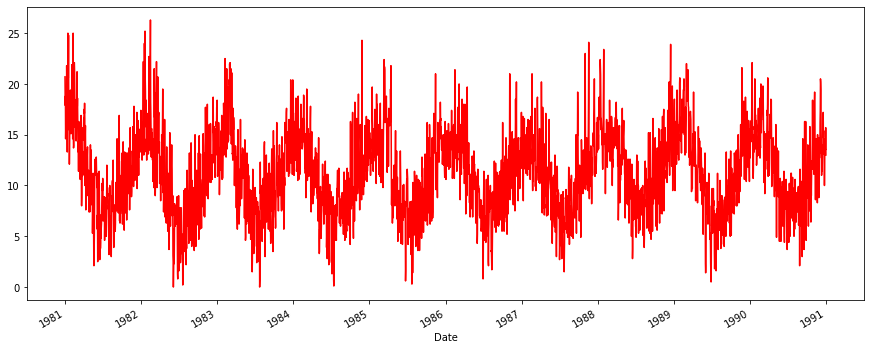

In [14]:
df.Temp.plot(figsize=(15, 6), color='red')

## Dataset Spliting

In [15]:
ts_train, ts_test = train_test_split(df, shuffle=False)
ts_train.shape, ts_test.shape

((2737, 5), (913, 5))

## Dataset & Dataloader

In [16]:
from jcopdl.utils import TimeSeriesDataset
from torch.utils.data import DataLoader

In [18]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
train_loader = DataLoader(train_set, batch_size=bs, num_workers=2)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
test_loader = DataLoader(test_set, batch_size=bs, num_workers=2)

(N, S, F): (195, 14, 5)
Note: last 6 data excluded

(N, S, F): (65, 14, 5)
Note: last 2 data excluded



## Arsitektur & Config

In [19]:
class GRU(nn.Module):
  def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, hidden):
    x, hidden = self.gru(x, hidden)
    x = self.fc(x)
    return x, hidden

In [21]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size": 1,
    "hidden_size":64,
    "num_layers": 2,
    "dropout":0
})

## Training Preparation -> MCOC

In [22]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='/content/data/model/multivariate')

## Training

In [23]:
from tqdm import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  cost = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output, hidden = model(feature, None)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    cost += loss.item() * feature.shape[0]
  cost = cost / len(dataset)
  return cost

Test: 100%|██████████| 3/3 [00:00<00:00, 66.32it/s]



Epoch     1
Train_cost  = 123.4973 | Test_cost  = 109.0946 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 63.99it/s]



Epoch     2
Train_cost  = 96.2909 | Test_cost  = 84.3828 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.72it/s]



Epoch     3
Train_cost  = 74.9397 | Test_cost  = 67.7834 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.90it/s]



Epoch     4
Train_cost  = 61.1397 | Test_cost  = 57.0142 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 61.73it/s]



Epoch     5
Train_cost  = 51.9687 | Test_cost  = 49.3493 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.60it/s]



Epoch     6
Train_cost  = 45.3043 | Test_cost  = 43.4622 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 65.11it/s]



Epoch     7
Train_cost  = 40.0855 | Test_cost  = 38.6427 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 62.23it/s]



Epoch     8
Train_cost  = 35.7693 | Test_cost  = 34.5634 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 69.71it/s]



Epoch     9
Train_cost  = 32.1281 | Test_cost  = 31.1204 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 52.05it/s]



Epoch    10
Train_cost  = 29.0839 | Test_cost  = 28.2433 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 53.05it/s]



Epoch    11
Train_cost  = 26.5615 | Test_cost  = 25.8546 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 61.98it/s]



Epoch    12
Train_cost  = 24.4872 | Test_cost  = 23.8856 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 65.42it/s]



Epoch    13
Train_cost  = 22.7960 | Test_cost  = 22.2754 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.28it/s]



Epoch    14
Train_cost  = 21.4297 | Test_cost  = 20.9689 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.74it/s]



Epoch    15
Train_cost  = 20.3359 | Test_cost  = 19.9167 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 66.47it/s]



Epoch    16
Train_cost  = 19.4680 | Test_cost  = 19.0753 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 64.61it/s]



Epoch    17
Train_cost  = 18.7852 | Test_cost  = 18.4067 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 66.85it/s]



Epoch    18
Train_cost  = 18.2521 | Test_cost  = 17.8784 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 64.50it/s]



Epoch    19
Train_cost  = 17.8389 | Test_cost  = 17.4627 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.93it/s]



Epoch    20
Train_cost  = 17.5204 | Test_cost  = 17.1368 | 


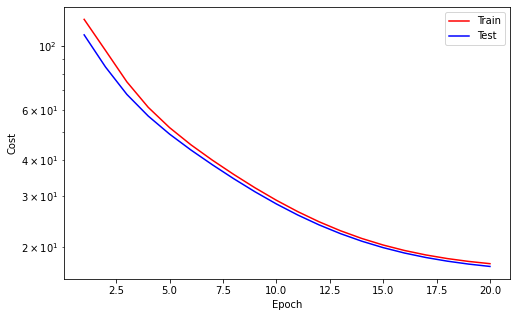

Test: 100%|██████████| 3/3 [00:00<00:00, 58.17it/s]



Epoch    21
Train_cost  = 17.2762 | Test_cost  = 16.8819 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 61.02it/s]



Epoch    22
Train_cost  = 17.0895 | Test_cost  = 16.6827 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 67.33it/s]



Epoch    23
Train_cost  = 16.9470 | Test_cost  = 16.5270 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.28it/s]



Epoch    24
Train_cost  = 16.8382 | Test_cost  = 16.4052 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 62.72it/s]



Epoch    25
Train_cost  = 16.7548 | Test_cost  = 16.3096 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.45it/s]



Epoch    26
Train_cost  = 16.6907 | Test_cost  = 16.2343 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.67it/s]



Epoch    27
Train_cost  = 16.6409 | Test_cost  = 16.1747 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 64.32it/s]



Epoch    28
Train_cost  = 16.6018 | Test_cost  = 16.1272 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 61.36it/s]



Epoch    29
Train_cost  = 16.5707 | Test_cost  = 16.0891 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 67.90it/s]



Epoch    30
Train_cost  = 16.5454 | Test_cost  = 16.0583 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 60.02it/s]



Epoch    31
Train_cost  = 16.5245 | Test_cost  = 16.0330 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 62.51it/s]



Epoch    32
Train_cost  = 16.5068 | Test_cost  = 16.0120 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 55.46it/s]



Epoch    33
Train_cost  = 16.4912 | Test_cost  = 15.9942 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.95it/s]



Epoch    34
Train_cost  = 16.4770 | Test_cost  = 15.9789 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.24it/s]



Epoch    35
Train_cost  = 16.4637 | Test_cost  = 15.9651 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 60.34it/s]



Epoch    36
Train_cost  = 16.4505 | Test_cost  = 15.9522 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 69.08it/s]



Epoch    37
Train_cost  = 16.4368 | Test_cost  = 15.9396 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 65.18it/s]



Epoch    38
Train_cost  = 16.4217 | Test_cost  = 15.9262 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 60.78it/s]



Epoch    39
Train_cost  = 16.4039 | Test_cost  = 15.9109 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 64.90it/s]



Epoch    40
Train_cost  = 16.3814 | Test_cost  = 15.8919 | 


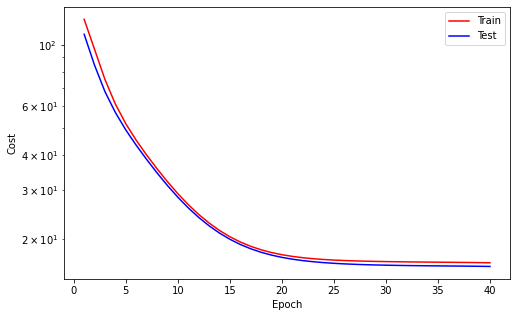

Test: 100%|██████████| 3/3 [00:00<00:00, 60.00it/s]



Epoch    41
Train_cost  = 16.3512 | Test_cost  = 15.8663 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.88it/s]



Epoch    42
Train_cost  = 16.3071 | Test_cost  = 15.8261 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 53.29it/s]


Epoch    43
Train_cost  = 16.2319 | Test_cost  = 15.7427 | 



Test: 100%|██████████| 3/3 [00:00<00:00, 66.39it/s]



Epoch    44
Train_cost  = 16.0564 | Test_cost  = 15.4573 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.43it/s]



Epoch    45
Train_cost  = 15.5283 | Test_cost  = 14.9668 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 61.40it/s]



Epoch    46
Train_cost  = 14.6591 | Test_cost  = 13.9497 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.53it/s]



Epoch    47
Train_cost  = 13.4861 | Test_cost  = 12.9449 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.95it/s]



Epoch    48
Train_cost  = 12.3633 | Test_cost  = 12.0686 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.39it/s]



Epoch    49
Train_cost  = 11.6120 | Test_cost  = 11.3822 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.50it/s]



Epoch    50
Train_cost  = 10.9520 | Test_cost  = 10.7267 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 55.24it/s]



Epoch    51
Train_cost  = 10.3503 | Test_cost  = 10.1703 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 55.11it/s]



Epoch    52
Train_cost  = 9.8680 | Test_cost  = 9.6922 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 58.05it/s]



Epoch    53
Train_cost  = 9.4596 | Test_cost  = 9.2952 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.40it/s]



Epoch    54
Train_cost  = 9.1189 | Test_cost  = 8.9737 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.48it/s]



Epoch    55
Train_cost  = 8.8263 | Test_cost  = 8.6993 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.05it/s]



Epoch    56
Train_cost  = 8.5753 | Test_cost  = 8.4527 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 60.94it/s]



Epoch    57
Train_cost  = 8.3554 | Test_cost  = 8.2302 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 62.39it/s]



Epoch    58
Train_cost  = 8.1613 | Test_cost  = 8.0327 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 62.92it/s]



Epoch    59
Train_cost  = 7.9893 | Test_cost  = 7.8560 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.65it/s]



Epoch    60
Train_cost  = 7.8368 | Test_cost  = 7.6969 | 


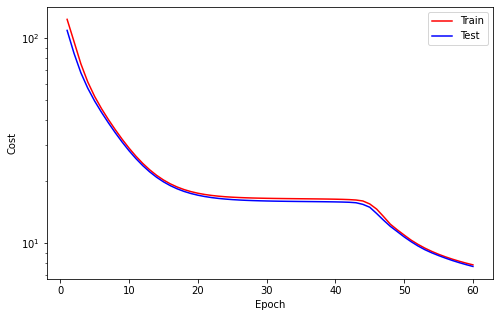

Test: 100%|██████████| 3/3 [00:00<00:00, 59.48it/s]



Epoch    61
Train_cost  = 7.7008 | Test_cost  = 7.5548 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 61.89it/s]



Epoch    62
Train_cost  = 7.5785 | Test_cost  = 7.4259 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 53.26it/s]



Epoch    63
Train_cost  = 7.4689 | Test_cost  = 7.3079 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 52.68it/s]



Epoch    64
Train_cost  = 7.3699 | Test_cost  = 7.2010 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.95it/s]



Epoch    65
Train_cost  = 7.2797 | Test_cost  = 7.1039 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 61.92it/s]



Epoch    66
Train_cost  = 7.1973 | Test_cost  = 7.0149 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 49.29it/s]



Epoch    67
Train_cost  = 7.1219 | Test_cost  = 6.9333 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.38it/s]



Epoch    68
Train_cost  = 7.0524 | Test_cost  = 6.8580 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 49.89it/s]



Epoch    69
Train_cost  = 6.9883 | Test_cost  = 6.7877 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.76it/s]



Epoch    70
Train_cost  = 6.9291 | Test_cost  = 6.7223 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.08it/s]



Epoch    71
Train_cost  = 6.8740 | Test_cost  = 6.6610 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 62.40it/s]



Epoch    72
Train_cost  = 6.8227 | Test_cost  = 6.6032 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.61it/s]



Epoch    73
Train_cost  = 6.7750 | Test_cost  = 6.5486 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.47it/s]



Epoch    74
Train_cost  = 6.7305 | Test_cost  = 6.4971 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 67.07it/s]



Epoch    75
Train_cost  = 6.6890 | Test_cost  = 6.4484 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.56it/s]



Epoch    76
Train_cost  = 6.6503 | Test_cost  = 6.4025 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 62.55it/s]



Epoch    77
Train_cost  = 6.6142 | Test_cost  = 6.3594 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.81it/s]



Epoch    78
Train_cost  = 6.5804 | Test_cost  = 6.3187 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.08it/s]



Epoch    79
Train_cost  = 6.5487 | Test_cost  = 6.2802 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 55.96it/s]



Epoch    80
Train_cost  = 6.5188 | Test_cost  = 6.2439 | 


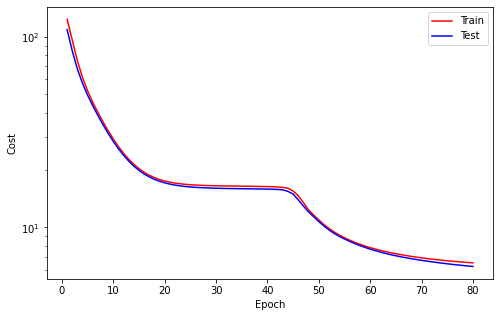

Test: 100%|██████████| 3/3 [00:00<00:00, 54.57it/s]



Epoch    81
Train_cost  = 6.4905 | Test_cost  = 6.2094 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 63.26it/s]



Epoch    82
Train_cost  = 6.4636 | Test_cost  = 6.1767 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 53.66it/s]



Epoch    83
Train_cost  = 6.4380 | Test_cost  = 6.1455 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.15it/s]



Epoch    84
Train_cost  = 6.4136 | Test_cost  = 6.1158 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 61.74it/s]


Epoch    85
Train_cost  = 6.3901 | Test_cost  = 6.0875 | 



Test: 100%|██████████| 3/3 [00:00<00:00, 56.83it/s]



Epoch    86
Train_cost  = 6.3676 | Test_cost  = 6.0606 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 53.81it/s]



Epoch    87
Train_cost  = 6.3458 | Test_cost  = 6.0349 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.26it/s]



Epoch    88
Train_cost  = 6.3248 | Test_cost  = 6.0104 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.24it/s]



Epoch    89
Train_cost  = 6.3045 | Test_cost  = 5.9872 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 43.56it/s]



Epoch    90
Train_cost  = 6.2849 | Test_cost  = 5.9651 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.44it/s]



Epoch    91
Train_cost  = 6.2660 | Test_cost  = 5.9440 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.32it/s]



Epoch    92
Train_cost  = 6.2477 | Test_cost  = 5.9238 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 64.25it/s]



Epoch    93
Train_cost  = 6.2300 | Test_cost  = 5.9047 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 53.28it/s]



Epoch    94
Train_cost  = 6.2128 | Test_cost  = 5.8865 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 58.05it/s]



Epoch    95
Train_cost  = 6.1962 | Test_cost  = 5.8692 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 64.06it/s]



Epoch    96
Train_cost  = 6.1801 | Test_cost  = 5.8527 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 63.16it/s]



Epoch    97
Train_cost  = 6.1644 | Test_cost  = 5.8370 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.84it/s]



Epoch    98
Train_cost  = 6.1491 | Test_cost  = 5.8220 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.51it/s]



Epoch    99
Train_cost  = 6.1341 | Test_cost  = 5.8077 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.96it/s]



Epoch   100
Train_cost  = 6.1196 | Test_cost  = 5.7940 | 


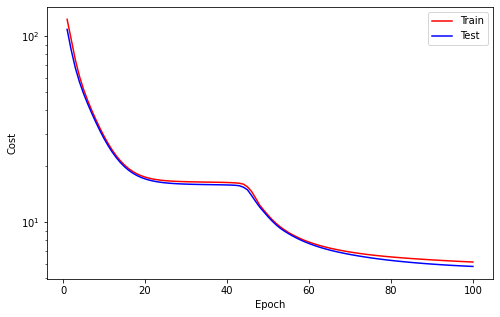

Test: 100%|██████████| 3/3 [00:00<00:00, 53.37it/s]



Epoch   101
Train_cost  = 6.1054 | Test_cost  = 5.7809 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 58.84it/s]



Epoch   102
Train_cost  = 6.0915 | Test_cost  = 5.7684 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.47it/s]



Epoch   103
Train_cost  = 6.0779 | Test_cost  = 5.7563 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.85it/s]



Epoch   104
Train_cost  = 6.0646 | Test_cost  = 5.7446 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 58.67it/s]



Epoch   105
Train_cost  = 6.0515 | Test_cost  = 5.7333 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.20it/s]



Epoch   106
Train_cost  = 6.0388 | Test_cost  = 5.7223 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.98it/s]



Epoch   107
Train_cost  = 6.0262 | Test_cost  = 5.7116 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.98it/s]



Epoch   108
Train_cost  = 6.0139 | Test_cost  = 5.7012 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 55.49it/s]



Epoch   109
Train_cost  = 6.0017 | Test_cost  = 5.6908 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.37it/s]



Epoch   110
Train_cost  = 5.9898 | Test_cost  = 5.6806 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 62.01it/s]



Epoch   111
Train_cost  = 5.9779 | Test_cost  = 5.6704 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.00it/s]



Epoch   112
Train_cost  = 5.9661 | Test_cost  = 5.6600 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.51it/s]



Epoch   113
Train_cost  = 5.9545 | Test_cost  = 5.6495 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.11it/s]



Epoch   114
Train_cost  = 5.9430 | Test_cost  = 5.6391 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.96it/s]



Epoch   115
Train_cost  = 5.9320 | Test_cost  = 5.6293 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 58.35it/s]



Epoch   116
Train_cost  = 5.9214 | Test_cost  = 5.6208 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 65.59it/s]



Epoch   117
Train_cost  = 5.9113 | Test_cost  = 5.6133 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 66.05it/s]



Epoch   118
Train_cost  = 5.9012 | Test_cost  = 5.6065 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 52.34it/s]



Epoch   119
Train_cost  = 5.8912 | Test_cost  = 5.6000 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 57.45it/s]



Epoch   120
Train_cost  = 5.8811 | Test_cost  = 5.5936 | 


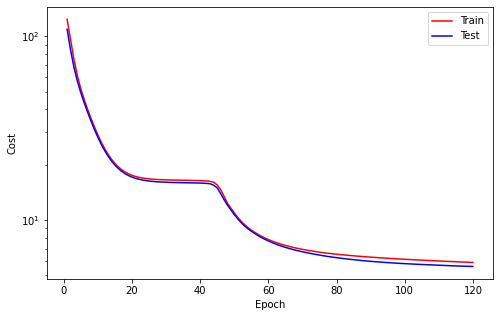

Test: 100%|██████████| 3/3 [00:00<00:00, 64.13it/s]



Epoch   121
Train_cost  = 5.8712 | Test_cost  = 5.5870 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 59.97it/s]



Epoch   122
Train_cost  = 5.8615 | Test_cost  = 5.5806 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.74it/s]



Epoch   123
Train_cost  = 5.8520 | Test_cost  = 5.5744 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 49.41it/s]



Epoch   124
Train_cost  = 5.8428 | Test_cost  = 5.5686 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.79it/s]



Epoch   125
Train_cost  = 5.8338 | Test_cost  = 5.5633 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 54.99it/s]



Epoch   126
Train_cost  = 5.8250 | Test_cost  = 5.5587 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.81it/s]



Epoch   127
Train_cost  = 5.8163 | Test_cost  = 5.5546 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.43it/s]



Epoch   128
Train_cost  = 5.8076 | Test_cost  = 5.5511 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.41it/s]



Epoch   129
Train_cost  = 5.7989 | Test_cost  = 5.5481 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 56.57it/s]



Epoch   130
Train_cost  = 5.7902 | Test_cost  = 5.5456 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.45it/s]



Epoch   131
Train_cost  = 5.7816 | Test_cost  = 5.5434 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.15it/s]



Epoch   132
Train_cost  = 5.7731 | Test_cost  = 5.5416 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.89it/s]



Epoch   133
Train_cost  = 5.7645 | Test_cost  = 5.5401 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.36it/s]



Epoch   134
Train_cost  = 5.7561 | Test_cost  = 5.5389 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.09it/s]



Epoch   135
Train_cost  = 5.7477 | Test_cost  = 5.5379 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 41.99it/s]



Epoch   136
Train_cost  = 5.7394 | Test_cost  = 5.5373 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 64.35it/s]



Epoch   137
Train_cost  = 5.7311 | Test_cost  = 5.5370 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 58.92it/s]



Epoch   138
Train_cost  = 5.7229 | Test_cost  = 5.5370 | 
==> EarlyStop patience =  1 | Best test_cost: 5.5370


Test: 100%|██████████| 3/3 [00:00<00:00, 49.50it/s]



Epoch   139
Train_cost  = 5.7147 | Test_cost  = 5.5374 | 
==> EarlyStop patience =  2 | Best test_cost: 5.5370


Test: 100%|██████████| 3/3 [00:00<00:00, 50.02it/s]



Epoch   140
Train_cost  = 5.7066 | Test_cost  = 5.5382 | 


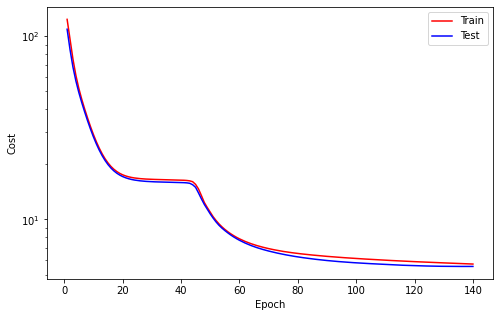

==> EarlyStop patience =  3 | Best test_cost: 5.5370


Test: 100%|██████████| 3/3 [00:00<00:00, 60.00it/s]



Epoch   141
Train_cost  = 5.6985 | Test_cost  = 5.5394 | 
==> EarlyStop patience =  4 | Best test_cost: 5.5370


Test: 100%|██████████| 3/3 [00:00<00:00, 58.19it/s]



Epoch   142
Train_cost  = 5.6904 | Test_cost  = 5.5409 | 
==> EarlyStop patience =  5 | Best test_cost: 5.5370
==> Execute Early Stopping at epoch: 142 | Best test_cost: 5.5370
==> Best model is saved at /content/data/model/multivariate


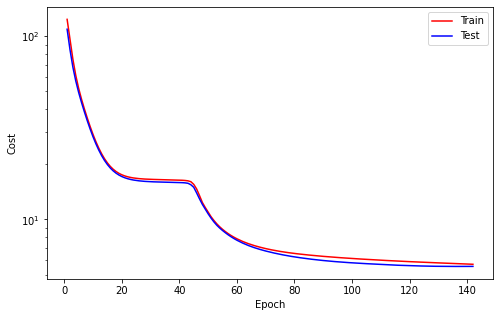

In [24]:
while True:
  train_cost = loop_fn("train", train_set, train_loader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost= loop_fn("test", test_set, test_loader, model, criterion, optimizer, device)

  #Logging
  callback.log(train_cost, test_cost)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime_plotting
  callback.cost_runtime_plotting()

  #Early stopping
  if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [25]:
# utils
def data4pred(model, dataset, dataloader, device):    
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)
            
            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks, targets, 'b-', label="data")
    plt.plot(dataset.target_ticks, preds, 'r-', label="pred")
    plt.legend()    
    
def pred4pred(model, dataset, dataloader, device, n_prior=500, n_forecast=200):
    preds, targets = [], []
    hidden = None    
    end = n_prior + n_forecast    
    with torch.no_grad():
        model.eval()       
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]
                
            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)
            
            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()   
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label="unseen_data", alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, 'r-', label="prediction")
    plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle="--", linewidth=1)
    plt.legend()   

In [26]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2736, 1, 5)
Note: last 0 data excluded

(N, S, F): (912, 1, 5)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

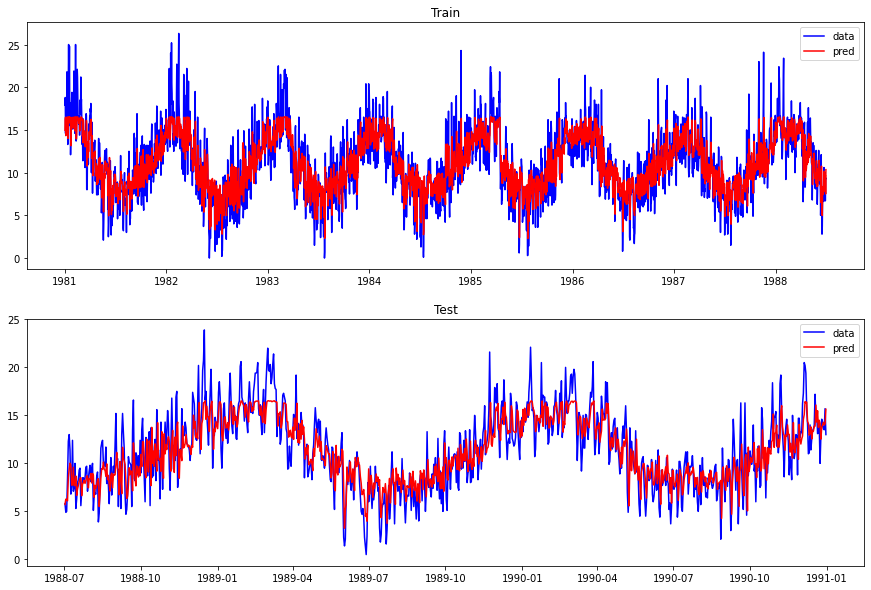

In [27]:
# Data 4 Pred
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

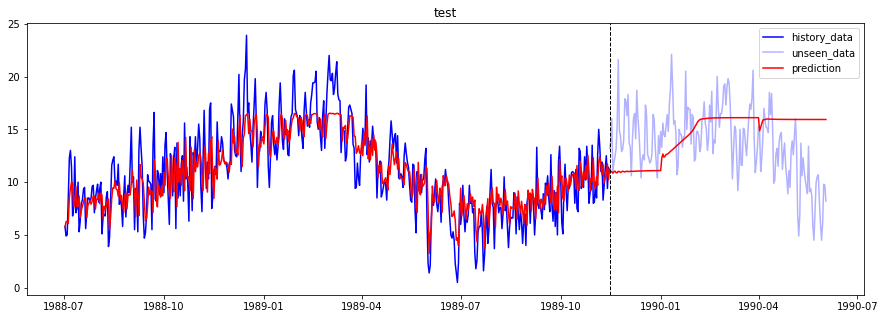

In [28]:
# Pred 4 Pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")